<a href="https://colab.research.google.com/github/sajad95/Flowise/blob/main/RNN_electriicty_U_ottawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1.	[Importing libraries](#1)
2.	[Functions](#2)
3.	[Data cleaning](#3)
   - 3.1 [Adding weather data](#3.1)
   - 3.2 [Backward Elimination](#3.2)
   - 3.3 [Adding hour, day of week and month  with a fromat of yyyy-mm-dd-hh-mm-ss](#3.3)

4. [Feature selection](#4)
   - 4.1 [Visulazing data to get a general idea](#4.1)
   - 4.2 [Correlation matrix heat map](#4.2)
5. [Hyper parameter Tunnin](#5)
   - 5.1 [Specifying train and test set and normalizing data](#5.1)
   - 5.2 [Run RNN with hyperparametres from literature](#5.2)
   - 5.3 [Optimizing batch size](#5.3)
   - 5.4 [Specifying train and test set and normalizing data](#5.4)
   - 5.5 [Run RNN with hyperparametres from literature](#5.5)
   - 5.6 [Optimizing batch size](#5.6)
   - 5.7 [Learning rate](#5.7)
   - 5.8 [Number of neurons](#5.8)
   - 5.9 [Number of layers](#5.9)
   - 5.10 [Epoch](#5.10)
   - 5.11 [historical length](#5.11)
   - 5.12 [Final RNN model](#5.12)
   - 5.13 [RNN+ attention layer](#5.13)
   - 5.14 [CNNRNN](#5.14)

6. [Post Processing](#6)   
7. [References](#7)

# **1. Importingt librarries** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from pandas import concat
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [ ]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas import DataFrame
from pandas import concat
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Flatten

from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten,Conv1D,Dropout,MaxPooling1D,AveragePooling1D
# saving and loading the .h5 model
from keras.models import Model
# define the model architecture
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import LSTM, Dropout, Dense, Input, Dot, Activation
from keras.layers import SimpleRNN
#####
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# make the model reproducible Ask Luc
import time
import os
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.optimizers import Adam
from keras.losses import Huber
from keras import backend as K
from random import seed

# **2. Functions** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)

In [ ]:
class Metric:
    def __init__(self):
        self.metrics = pd.DataFrame(columns=['R-squared', 'MAE', 'MSE', 'CVRMSE', 'Overprediction', 'Underprediction'])

    def add(self, y_true, y_pred):
        residuals = y_true - y_pred
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        mae = np.mean(np.abs(residuals))
        mse = np.mean(residuals ** 2)
        rmse = np.sqrt(mse)
        cvrmse = (rmse / np.mean(y_true)) * 100

        overprediction, underprediction = self.over_under_prediction(y_true, y_pred)

        self.metrics.loc[len(self.metrics)] = [r_squared, mae, mse, cvrmse, overprediction, underprediction]

    def get(self):
        return self.metrics

    def over_under_prediction(self, y_true, y_pred):
        overprediction = np.mean(np.where(y_pred > y_true, 1, 0))
        underprediction = np.mean(np.where(y_pred < y_true, 1, 0))
        return overprediction, underprediction


def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Data is splitted with thime (Miroslava)

import pandas as pd

def normalize_data(dataframe):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(dataframe)
    normalized_dataframe = pd.DataFrame(normalized_data, columns=dataframe.columns)
    return normalized_dataframe


def split_data(series):
    """Splits input series into train, val and test.
    """
    train_data = series[:]
    test_data = series[:]
    return train_data, test_data
# split a multivariate sequence into samples
# data with time as feature

# **3. Data preperation** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

In [ ]:
# mounting google drive and uploading the data
drive.mount('/content/saj')

Mounted at /content/saj


In [ ]:
def load_data(col=None, path='/content/saj/MyDrive/uni kavgic/electricUottawa/raw data for electricty all buildings 2016 only.xlsx', verbose=False ):
    df = pd.read_excel(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df
df = load_data()

In [ ]:
df.head(2)

,Time,1 Stewart St,55 Laurier Ave E,200 Lees Ave,200 Lees Ave.1,157 Laurier Ave E,801 King Edward Ave,25 Templeton St,600 Peter Morand Cres,850 Peter Morand Cres,65 Universite Pvt,202 Henderson Ave,240 Friel St,290 Rideau St
0,2016-01-01 00:00:00,15.185,205.56,192.852,25.16,66.864,252.0,364.59,52.32,19.728,4537.44,38.808,108.468,190.83
1,2016-01-01 01:00:00,15.152,209.88,195.624,25.24,66.528,215.1,364.77,52.11,19.332,4511.52,39.996,113.796,198.27


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Time                       8784 non-null   datetime64[ns]
 1   1 Stewart St               8784 non-null   float64       
 2            55 Laurier Ave E  8784 non-null   float64       
 3   200 Lees Ave               8784 non-null   float64       
 4   200 Lees Ave.1             8784 non-null   float64       
 5   157 Laurier Ave E          8784 non-null   float64       
 6   801 King Edward Ave        8784 non-null   float64       
 7   25 Templeton St            8784 non-null   float64       
 8   600 Peter Morand Cres      8784 non-null   float64       
 9   850 Peter Morand Cres      8784 non-null   float64       
 10  65 Universite Pvt          8784 non-null   float64       
 11  202 Henderson Ave          8784 non-null   float64       
 12  240 Fr

In [ ]:
df.columns = df.columns.str.replace(' ', '')

## **3.1 What are the biggest consumers ?** <a class="anchor" id="3.1"></a>

[Table of Contents](#0.1)

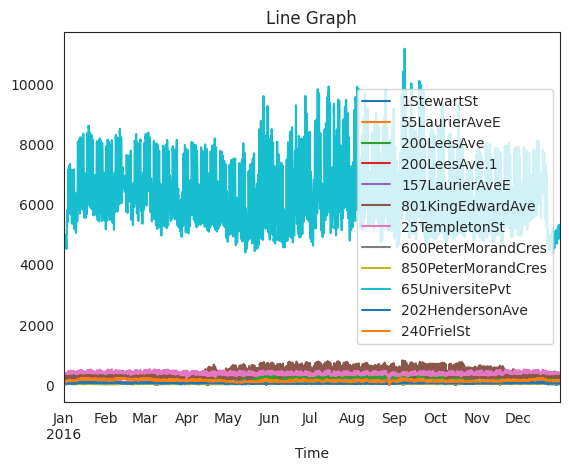

In [ ]:
# prompt: Turn column 2 to 8 to line graph and compare them.
df.plot(x='Time', y=df.columns.values[1:13], title='Line Graph' )
plt.show()

<ipython-input-10-bbadcf52715e>:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.sum().plot(kind='bar', title='')


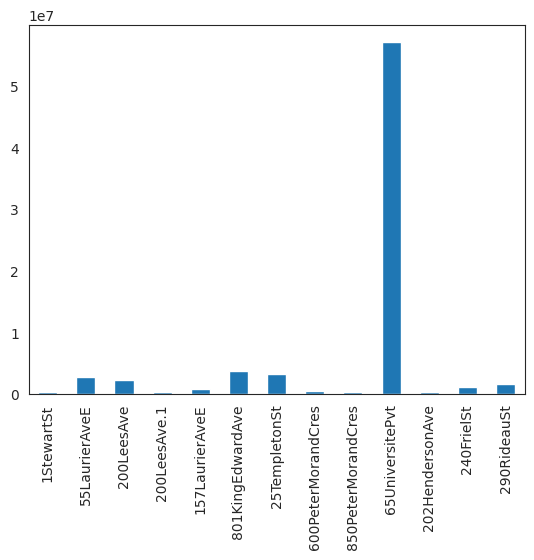

In [ ]:
# prompt: develop bar chart showing the total of each column from column 1 to 9
df.sum().plot(kind='bar', title='')
plt.show()

In [ ]:
# prompt: filter columns with thier names and make a new dataframe
df1 = df[['Time','65UniversitePvt', '801KingEdwardAve']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              8784 non-null   datetime64[ns]
 1   65UniversitePvt   8784 non-null   float64       
 2   801KingEdwardAve  8784 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 206.0 KB


In [ ]:
# prompt: add columns one to 9 and generate new column as total.
df1['Total'] = df1.sum(axis=1)

<ipython-input-12-e22a2f51c2d1>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['Total'] = df1.sum(axis=1)
<ipython-input-12-e22a2f51c2d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Total'] = df1.sum(axis=1)


In [ ]:
df1

,Time,65UniversitePvt,801KingEdwardAve,Total
0,2016-01-01 00:00:00,4537.44,252.00,4789.44
1,2016-01-01 01:00:00,4511.52,215.10,4726.62
2,2016-01-01 02:00:00,4505.76,238.23,4743.99
3,2016-01-01 03:00:00,4512.96,192.60,4705.56
4,2016-01-01 04:00:00,4583.52,230.49,4814.01
...,...,...,...,...
8779,2016-12-31 19:00:00,5140.80,321.66,5462.46
8780,2016-12-31 20:00:00,5074.56,286.74,5361.30
8781,2016-12-31 21:00:00,5060.16,317.70,5377.86
8782,2016-12-31 22:00:00,5005.44,297.36,5302.80



## **3.2 Adding weather data** <a class="anchor" id="3.2"></a>

[Table of Contents](#0.1)

https://climate-change.canada.ca/climate-data/#/hourly-climate-data

In [ ]:

dfwea = load_data(col=None, path='/content/saj/MyDrive/uni kavgic/electricUottawa/weather.xlsx', verbose=False)

In [ ]:
#dfwea = pd.read_excel('/content/saj/MyDrive/uni kavgic/electricUottawa/weather.xlsx')
dfwea.info()

dfwea = dfwea.rename(columns={'LOCAL_DATE': 'Time'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8782 entries, 0 to 8781
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   LOCAL_DATE  8782 non-null   datetime64[ns]
 1   TEMP        8782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.3 KB


In [ ]:
# Merge dataframes based on 'Date'
merged_df = pd.merge(dfwea, df1, on='Time', how='outer')

# Identify rows where either 'Time' is missing
non_matching_rows = merged_df[merged_df['Time'].isna()]

# Now non_matching_rows contains rows where the 'Time' column does not match

# If you want to drop rows with missing values in 'Time' (rows that don't have a match)
merged_df = merged_df.dropna(subset=['Time'])

# Now merged_df contains only the rows with matching 'Time' values


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              8784 non-null   datetime64[ns]
 1   TEMP              8782 non-null   float64       
 2   65UniversitePvt   8784 non-null   float64       
 3   801KingEdwardAve  8784 non-null   float64       
 4   Total             8784 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 411.8 KB


In [ ]:
# Drop rows with missing values
merged_df = merged_df.dropna()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8782 entries, 0 to 8781
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              8782 non-null   datetime64[ns]
 1   TEMP              8782 non-null   float64       
 2   65UniversitePvt   8782 non-null   float64       
 3   801KingEdwardAve  8782 non-null   float64       
 4   Total             8782 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 411.7 KB


In [ ]:
merged_df

,Time,TEMP,65UniversitePvt,801KingEdwardAve,Total
0,2016-01-01 00:00:00,-2.5,4537.44,252.00,4789.44
1,2016-01-01 01:00:00,-2.7,4511.52,215.10,4726.62
2,2016-01-01 02:00:00,-3.2,4505.76,238.23,4743.99
3,2016-01-01 03:00:00,-3.4,4512.96,192.60,4705.56
4,2016-01-01 04:00:00,-3.8,4583.52,230.49,4814.01
...,...,...,...,...,...
8777,2016-12-31 19:00:00,-8.6,5140.80,321.66,5462.46
8778,2016-12-31 20:00:00,-8.8,5074.56,286.74,5361.30
8779,2016-12-31 21:00:00,-8.6,5060.16,317.70,5377.86
8780,2016-12-31 22:00:00,-8.4,5005.44,297.36,5302.80


## **3.3 Extracting hour, day of week and month from Dat with a fromat of yyyy-mm-dd-hh-mm-ss** <a class="anchor" id="3.3"></a>

[Table of Contents](#0.1)

In [ ]:
merged_df['Time'] = merged_df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

<ipython-input-20-d8846a1ef6f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Time'] = merged_df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')


In [ ]:
#monday = 0
#sunday = 6
def make_time_features(series):

    #convert series to datetimes
    times = series.apply(lambda x: pd.to_datetime(x))
    datetimes = pd.DatetimeIndex(times)

    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values

    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')

    return hour, dayofw, month

hour, day, month = make_time_features(merged_df.Time)

In [ ]:
hours, day, months = make_time_features(merged_df.Time)
merged_df = pd.concat([merged_df, hours, day, months], axis=1)

In [ ]:
merged_df

,Time,TEMP,65UniversitePvt,801KingEdwardAve,Total,hours,dayofw,months
0,2016-01-01 00:00:00,-2.5,4537.44,252.00,4789.44,0,4,1
1,2016-01-01 01:00:00,-2.7,4511.52,215.10,4726.62,1,4,1
2,2016-01-01 02:00:00,-3.2,4505.76,238.23,4743.99,2,4,1
3,2016-01-01 03:00:00,-3.4,4512.96,192.60,4705.56,3,4,1
4,2016-01-01 04:00:00,-3.8,4583.52,230.49,4814.01,4,4,1
...,...,...,...,...,...,...,...,...
8777,2016-12-31 19:00:00,-8.6,5140.80,321.66,5462.46,19,5,12
8778,2016-12-31 20:00:00,-8.8,5074.56,286.74,5361.30,20,5,12
8779,2016-12-31 21:00:00,-8.6,5060.16,317.70,5377.86,21,5,12
8780,2016-12-31 22:00:00,-8.4,5005.44,297.36,5302.80,22,5,12


In [ ]:
merged_df['Time'] = pd.to_datetime(merged_df['Time'] , utc = True)

In [ ]:
merged_df = merged_df.set_index('Time')

In [ ]:
merged_df

,TEMP,65UniversitePvt,801KingEdwardAve,Total,hours,dayofw,months
Time,,,,,,,
2016-01-01 00:00:00+00:00,-2.5,4537.44,252.00,4789.44,0,4,1
2016-01-01 01:00:00+00:00,-2.7,4511.52,215.10,4726.62,1,4,1
2016-01-01 02:00:00+00:00,-3.2,4505.76,238.23,4743.99,2,4,1
2016-01-01 03:00:00+00:00,-3.4,4512.96,192.60,4705.56,3,4,1
2016-01-01 04:00:00+00:00,-3.8,4583.52,230.49,4814.01,4,4,1
...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,-8.6,5140.80,321.66,5462.46,19,5,12
2016-12-31 20:00:00+00:00,-8.8,5074.56,286.74,5361.30,20,5,12
2016-12-31 21:00:00+00:00,-8.6,5060.16,317.70,5377.86,21,5,12


In [ ]:
col = ['65UniversitePvt', '801KingEdwardAve']

merged_df = merged_df.drop(columns=col)

# **4. Feature selection** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

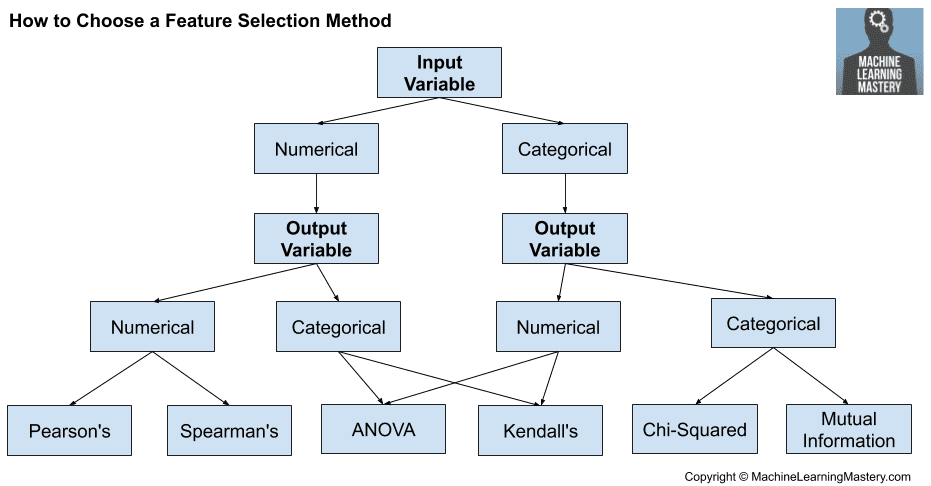

## **4.1 Visulazing data to get a general idea**<a class="anchor" id="4.1"></a>

[Table of Contents](#0.1)


<ipython-input-28-dd39ec835f6d>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df[col], ax=ax, kde=False, hist=True)


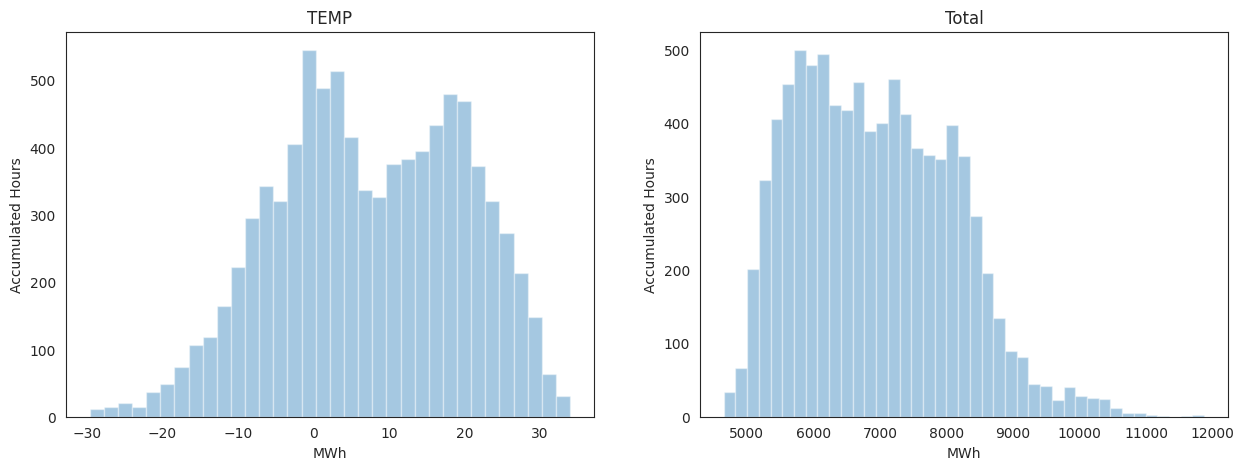

In [ ]:
#visualize the distributions
fig, axs = plt.subplots(1, 2, figsize=(15,5))

#cycle through subplots and columns
for ax, col in zip(axs, merged_df.columns):
    #histogram plot
    sns.distplot(merged_df[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title(col)
    ax.set_xlabel('MWh')
    ax.set_ylabel('Accumulated Hours')
    #set the y labels
    #ax.set_yticks(np.linspace(0, len(col), 10))
plt.show()

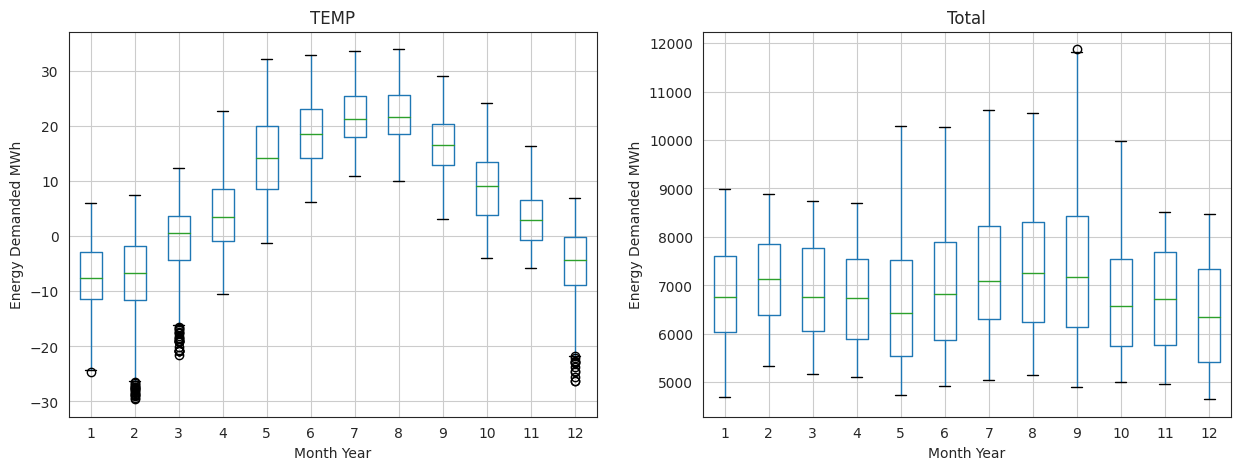

In [ ]:
### plot the monthly demand variability. Looking for seasonal effects

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, merged_df.columns):

    groups = merged_df[col].groupby(pd.Grouper(freq='M'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.month] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)


plt.show()

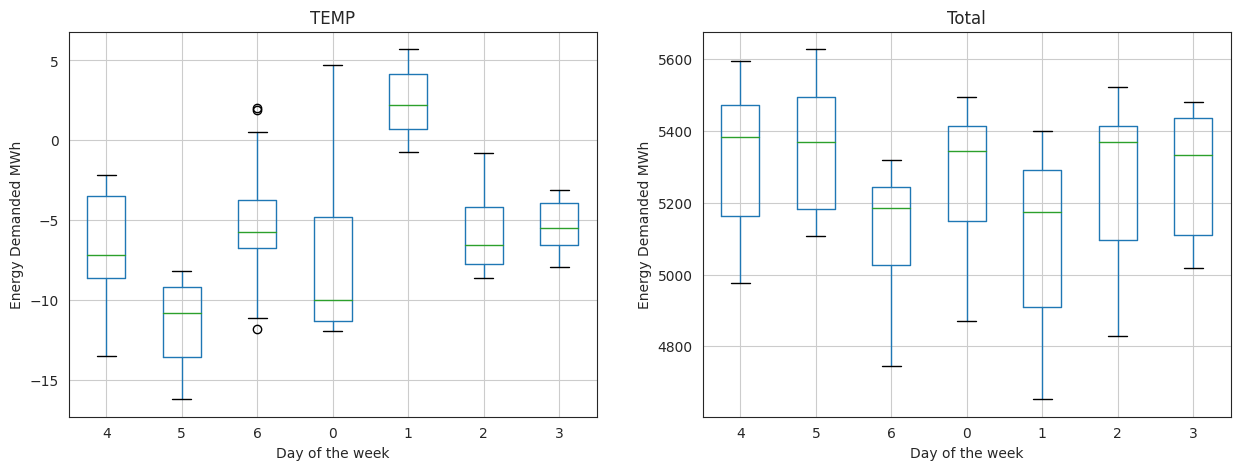

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, merged_df.columns):

    groups = merged_df[col].groupby(pd.Grouper(freq='D'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.dayofweek] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Day of the week')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)


plt.show()

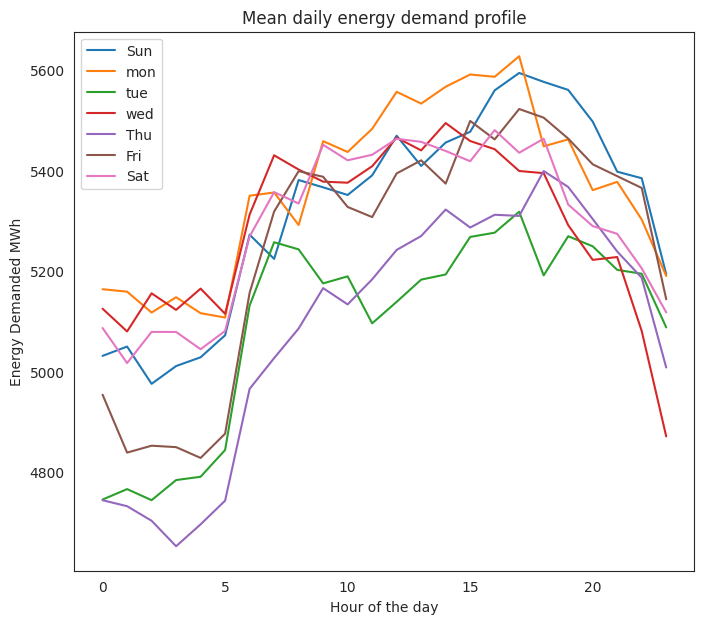

In [ ]:
group_hours = merged_df['Total'].groupby(pd.Grouper(freq='D', how='mean'))

day_names = ['Sun','mon', 'tue', 'wed', 'Thu', 'Fri', 'Sat']

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()

for name, group in group_hours:
    df[name.dayofweek] = pd.Series(group.values)

df.columns = day_names
df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');

## **4.2 Correlation-Matrix with Heatmap** <a class="anchor" id="4.2"></a>

# [Table of Contents](#0.1)

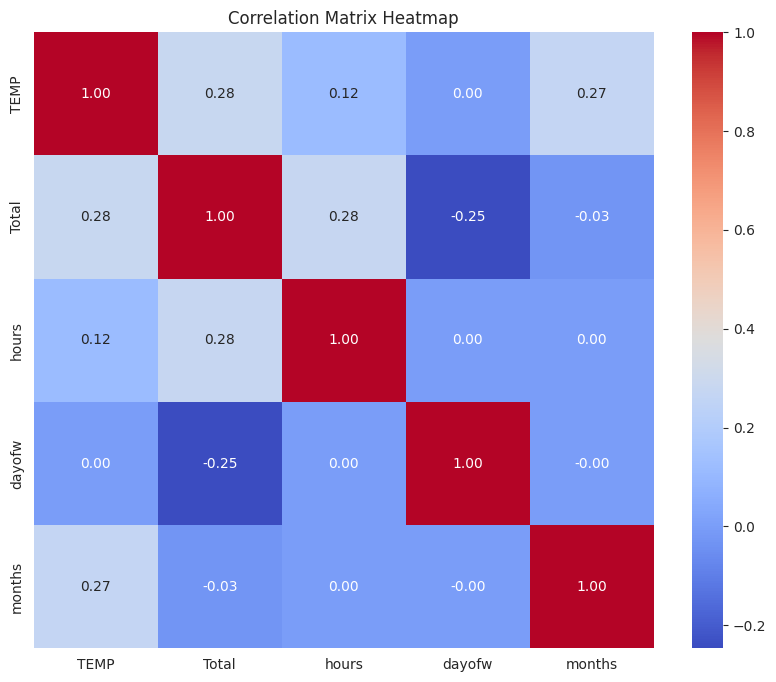

In [ ]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Set the title of the plot
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

# **5. Hyperparameter tunning** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)


## Specifying train and test sets

In [ ]:
df_cor_mat = merged_df.drop('months', axis=1)

In [ ]:
df_cor_mat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8782 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 23:00:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TEMP    8782 non-null   float64
 1   Total   8782 non-null   float64
 2   hours   8782 non-null   int64  
 3   dayofw  8782 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 343.0 KB


In [ ]:
s = df_cor_mat
train_multi, test_multi = split_data(s)
for j in s:
    def split_data(series):
        """Splits input series into train, val and test.
        """
        train_data = series[:6000]
        test_data = series[6000:]
        return train_data, test_data
    vars()[f"train_{j}"] = train_multi[j].values
    vars()[f"train_{j}"].reshape((len(train_multi[j]), 1))
    vars()[f"test_{j}"] = test_multi[j].values
    vars()[f"test_{j}"].reshape((len(vars()[f"test_{j}"]), 1))
out_seqt = train_Total
dataset = hstack((train_TEMP.reshape(-1, 1),train_hours.reshape(-1, 1),
                  train_dayofw.reshape(-1, 1),
                  train_Total.reshape(-1, 1), out_seqt.reshape(-1, 1)))

out_seqt_test = test_Total
dataset_test = hstack((test_TEMP.reshape(-1, 1),
                       test_hours.reshape(-1, 1),
                       test_dayofw.reshape(-1, 1),
                       test_Total.reshape(-1, 1), out_seqt_test.reshape(-1, 1)))

# Applying MinMax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)
dataset_test_scaled = scaler.transform(dataset_test)

n_steps_in, n_steps_out = 24, 24
X, y = split_sequences(dataset_scaled, n_steps_in, n_steps_out)
X1, y1 = split_sequences(dataset_test_scaled, n_steps_in, n_steps_out)
n_features = X.shape[2]

# Reshape input data to have 3D shape
X = X.reshape((X.shape[0], n_steps_in, n_features))
X1 = X1.reshape((X1.shape[0], n_steps_in, n_features))

# Run the mode with Hyperparameters from  literature

https://machinelearningmastery.com/an-introduction-to-recurrent-neural-networks-and-the-math-that-powers-them/

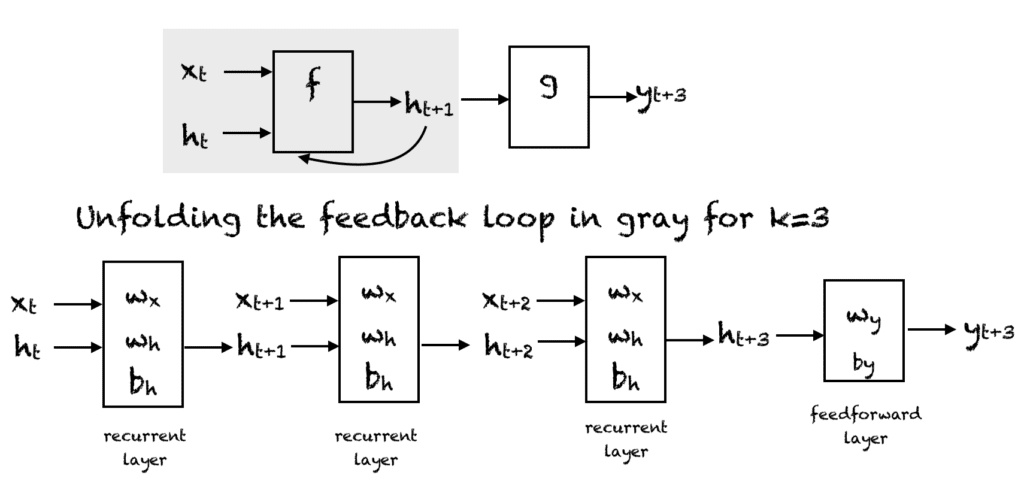

In [ ]:
def train_rnn_model( epochs=50, batch_size=32, learning_rate=0.001, early_stopping_patience=10, activations=['tanh','relu']):
    # Create a Sequential model
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(100, activation=activations[0], return_sequences=False, input_shape=(n_steps_in, n_features)))
    model_rnn.add(Dense(n_steps_out, activation=activations[1]))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn


In [ ]:
# Example usage:
# Assuming n_steps_in, n_features, X, y, X1, y1 are defined
trained_model = train_rnn_model(  epochs=50, batch_size=32, learning_rate=0.001, early_stopping_patience=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
273/273 [==============================] - 11s 15ms/step - loss: 0.0057 - mse: 0.0114 - val_loss: 0.0037 - val_mse: 0.0074
Epoch 2/50
273/273 [==============================] - 4s 15ms/step - loss: 0.0029 - mse: 0.0057 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 3/50
273/273 [==============================] - 4s 16ms/step - loss: 0.0026 - mse: 0.0052 - val_loss: 0.0025 - val_mse: 0.0049
Epoch 4/50
273/2

In [ ]:
metric = Metric()
metric.add(y1, trained_model.predict(X1))
metrics_df = metric.get()
metrics_df

273/273 [==============================] - 2s 7ms/step


,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.907399,0.034775,0.00242,15.556102,0.472491,0.5275


## **5.1 Optimal Activation Function** <a class="anchor" id="5.1"></a>

# [Table of Contents](#0.1)

In [ ]:
def train_rnn_model( epochs=50, batch_size=32, learning_rate=0.001, early_stopping_patience=10, acti='tanh'):
    # Create a Sequential model
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(100, activation=acti, return_sequences=False, input_shape=(n_steps_in, n_features)))
    model_rnn.add(Dense(n_steps_out, activation='relu'))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn,history


In [ ]:
# Values of batch size to test
activations = ['tanh','relu','sigmoid']
metric = Metric()
for a in activations:
    # Train the model
    model_rnn, history = train_rnn_model( epochs=50, batch_size=32, learning_rate=0.001, early_stopping_patience=10,acti = a)
    y1_pred = model_rnn.predict(X1)
    metric.add(y1, y1_pred)
    metrics_df = metric.get()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
273/273 [==============================] - 12s 16ms/step - loss: 0.0059 - mse: 0.0119 - val_loss: 0.0032 - val_mse: 0.0064
Epoch 2/50
273/273 [==============================] - 4s 16ms/step - loss: 0.0028 - mse: 0.0055 - val_loss: 0.0024 - val_mse: 0.0049
Epoch 3/50
273/273 [==============================] - 4s 16ms/step - loss: 0.0026 - mse: 0.0052 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 4/50
273/2

In [ ]:
metrics_df

,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.900706,0.036070,0.002595,16.108454,0.454536,0.545464
1,0.927633,0.031178,0.001891,13.751912,0.512994,0.487002
2,-0.295624,0.109480,0.033858,58.187801,0.434030,0.565923


https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

# Optimizing Batch size

In [ ]:
def train_rnn_model( epochs=50, batch_size=32, learning_rate=0.001, early_stopping_patience=10, acti='relu'):
    # Create a Sequential model
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(100, activation=acti, return_sequences=False, input_shape=(n_steps_in, n_features)))
    model_rnn.add(Dense(n_steps_out, activation='relu'))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn,history


In [ ]:
# Values of batch size to test
batch_sizes_to_test = [1, 16, 32]
metric = Metric()
for b in batch_sizes_to_test:
    # Train the model
    model_rnn, history = train_rnn_model(epochs=50, batch_size=b, learning_rate=0.001, early_stopping_patience=10, acti='relu')
    y1_pred = model_rnn.predict(X1)
    metric.add(y1, y1_pred)
    metrics_df = metric.get()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10500     
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
8735/8735 [==============================] - 86s 10ms/step - loss: 0.0041 - mse: 0.0082 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 2/50
8735/8735 [==============================] - 83s 9ms/step - loss: 0.0022 - mse: 0.0045 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 3/50
8735/8735 [==============================] - 84s 10ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0018 - val_mse: 0.0037
Epoch 4

KeyboardInterrupt: ignored

In [ ]:
metrics_df

NameError: ignored

# learning rate

In [ ]:
tf.keras.backend.clear_session()

model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
model_rnn.add(Dense(n_steps_out, activation='relu'))

# Set the loss function and compile the model with the specified optimizer and learning rate
loss = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Display the model summary
model_rnn.summary()

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epoch = 300
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 80))

metric = Metric()
for batch_size in batch_sizes_to_test:
    # Train the model
    model_rnn, history = train_rnn_model(epochs=epoch, batch_size=16, learning_rate=lr_schedule, early_stopping_patience=10)
    y1_pred = model_rnn.predict(X1)
    metric.add(y1, y1_pred)
    metrics_df = metric.get()

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 80))

# Initialize the optimizer to Adamax
optimizer = tf.keras.optimizers.Adamax()

# Set the training parameters
model_rnn.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model for 10 epochs
history = model_rnn.fit(X, y, epochs=300, callbacks=[lr_schedule])

Epoch 1/300
273/273 [==============================] - 4s 8ms/step - loss: 0.0621 - lr: 1.0000e-06
Epoch 2/300
273/273 [==============================] - 2s 8ms/step - loss: 0.0567 - lr: 1.0292e-06
Epoch 3/300
273/273 [==============================] - 3s 10ms/step - loss: 0.0525 - lr: 1.0593e-06
Epoch 4/300
273/273 [==============================] - 3s 12ms/step - loss: 0.0493 - lr: 1.0902e-06
Epoch 5/300
273/273 [==============================] - 3s 11ms/step - loss: 0.0467 - lr: 1.1220e-06
Epoch 6/300
273/273 [==============================] - 2s 8ms/step - loss: 0.0446 - lr: 1.1548e-06
Epoch 7/300
273/273 [==============================] - 2s 8ms/step - loss: 0.0428 - lr: 1.1885e-06
Epoch 8/300
273/273 [==============================] - 2s 8ms/step - loss: 0.0410 - lr: 1.2232e-06
Epoch 9/300
273/273 [==============================] - 2s 8ms/step - loss: 0.0392 - lr: 1.2589e-06
Epoch 10/300
273/273 [==============================] - 2s 9ms/step - loss: 0.0374 - lr: 1.2957e-06
Epoch 

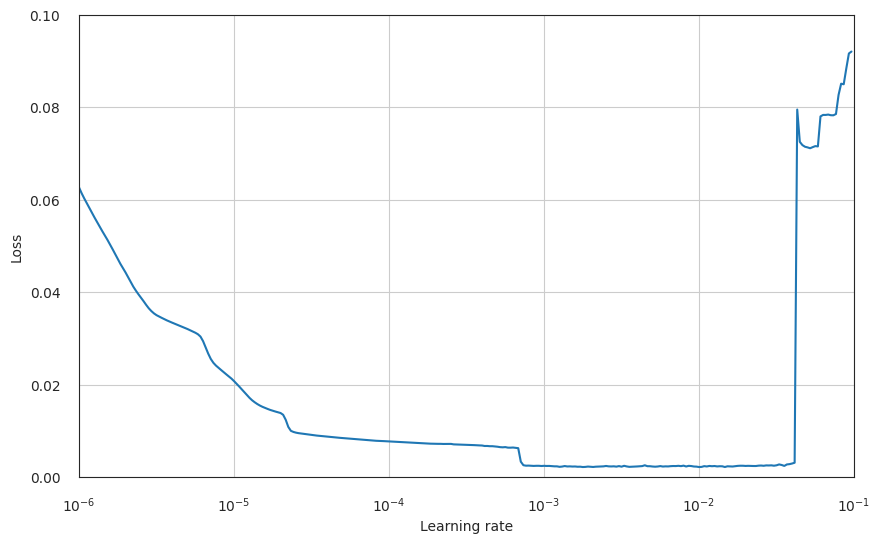

In [ ]:
# Define the learning rate array for 10 epochs

epoch=300
lrs = 1e-6 * (10 ** (np.arange(epoch) / 60))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the learning rates against the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tick marks size
plt.tick_params('both', length=10, width=1, which='both')


plt.xlabel('Learning rate')
plt.ylabel('Loss')
# Set the plot boundaries
plt.axis([1e-6, 1e-1, 0, 0.1])

# Show the plot
plt.show()

# Number of nuorons

In [ ]:
nueron = [16, 32, 64,100,128,256]
metric = Metric()

for n in nueron:
    tf.keras.backend.clear_session()
    model_rnn, history = train_rnn_model(X, y, n_steps_in, n_features, n_steps_out, epochs=50, batch_size= 16, learning_rate=0.001, early_stopping_patience=10,neurons=100)
    y1_pred = model_rnn.predict(X1)
    metric.add(y1, y1_pred)
    metrics_df = metric.get()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
492/492 [==============================] - 5s 8ms/step - loss: 0.0108 - mse: 0.0216 - val_loss: 0.0069 - val_mse: 0.0139
Epoch 2/50
492/492 [==============================] - 5s 11ms/step - loss: 0.0080 - mse: 0.0160 - val_loss: 0.0063 - val_mse: 0.0126
Epoch 3/50
492/492 [==============================] - 5s 10ms/step - loss: 0.0078 - mse: 0.0156 - val_loss: 0.0057 - val_mse: 0.0114
Epoch 4/50
492/492

In [ ]:
metrics_df

,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.873400,0.041825,0.003308,18.189032,0.534693,0.465307
1,0.879330,0.040359,0.003153,17.757917,0.501636,0.498364
2,0.882681,0.039526,0.003066,17.509593,0.457179,0.542811
3,0.872808,0.042509,0.003324,18.231476,0.666528,0.333472
4,0.888832,0.038443,0.002905,17.044446,0.483391,0.516609
5,0.689905,0.050258,0.008104,28.466903,0.445974,0.554021


# number of layers


In [ ]:
# Three layers
metric = Metric()

tf.keras.backend.clear_session()
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
model_rnn.add(Dense(n_steps_out, activation='relu'))
loss = tf.keras.losses.Huber()
model_rnn.compile(loss=loss, optimizer='adam', metrics=['mse'])
model_rnn.summary()
# fit model
#  To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#es = EarlyStopping(monitor='mse', mode='max', min_delta=1)
history = model_rnn.fit(X, y, epochs=50,batch_size = 16 ,verbose=1, validation_data=(X1, y1),
                        callbacks=[ early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 100)           10500     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 33024 (129.00 KB)
Trainable params: 33024 (129.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
546/546 [==============================] - 15s 21ms/step - loss: 0.0151 - mse: 0.0301 - val_loss: 0.0129 - val_mse: 0.0258
Epoch 2/50
546/546 [==============================] - 16s 30ms/step - loss: 0.0129 - mse: 0.0258 - val_loss: 0.0133 - val_mse: 0.0267
Epoch 3/50
546

In [ ]:
y1_pred = model_rnn.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()
metrics_df

273/273 [==============================] - 2s 6ms/step


,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.704497,0.049183,0.007722,27.78902,0.622992,0.377003


In [ ]:
# Four layers
metric = Metric()

tf.keras.backend.clear_session()
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
model_rnn.add(Dense(n_steps_out, activation='relu'))
loss = tf.keras.losses.Huber()
model_rnn.compile(loss=loss, optimizer='adam', metrics=['mse'])
model_rnn.summary()
# fit model
#  To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#es = EarlyStopping(monitor='mse', mode='max', min_delta=1)
history = model_rnn.fit(X, y, epochs=50,batch_size = 16 ,verbose=1, validation_data=(X1, y1),
                        callbacks=[ early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 100)           10500     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 53124 (207.52 KB)
Trainable params: 53124 (207.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
546/546 [==============================] - 32s 53ms/step - loss: 0.0321 - mse: 0.0642 - val_loss: 0.0306 - val_mse: 0.0611
Epoch 2/50
546/5

In [ ]:
y1_pred = model_rnn.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()
metrics_df

273/273 [==============================] - 3s 8ms/step


,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.910037,0.035586,0.002351,15.33293,0.370755,0.629245


In [ ]:
# Five layers
metric = Metric()

tf.keras.backend.clear_session()
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=False, input_shape=(n_steps_in, n_features)))
model_rnn.add(Dense(n_steps_out, activation='relu'))
loss = tf.keras.losses.Huber()
model_rnn.compile(loss=loss, optimizer='adam', metrics=['mse'])
model_rnn.summary()
# fit model
#  To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#es = EarlyStopping(monitor='mse', mode='max', min_delta=1)
history = model_rnn.fit(X, y, epochs=50,batch_size = 16 ,verbose=1, validation_data=(X1, y1),
                        callbacks=[ early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 100)           10500     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 73224 (286.03 KB)
Trainable params: 73224 (286.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
546/546

In [ ]:
y1_pred = model_rnn.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()
metrics_df

273/273 [==============================] - 4s 13ms/step


,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,-0.991334,0.145168,0.052038,72.138083,0.233949,0.766008


# Number of epochs => this is not important as we are using early stopping

In [ ]:
def train_rnn_model( epochs=50, batch_size=32, learning_rate=0.008, early_stopping_patience=10, acti='relu'):
    # Create a Sequential model
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(64, activation=acti, return_sequences=False, input_shape=(n_steps_in, n_features)))
    model_rnn.add(Dense(n_steps_out, activation='relu'))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn,history

In [ ]:
# Values of batch size to test
epoch = [50,100,150,300,400]
metric = Metric()
for a in epoch:
    # Train the model
    model_rnn, history = train_rnn_model( epochs =a , batch_size=32, learning_rate=0.008, early_stopping_patience=10, acti = 'relu')
    y1_pred = model_rnn.predict(X1)
    metric.add(y1, y1_pred)
    metrics_df = metric.get()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4416      
                                                                 
 dense_3 (Dense)             (None, 24)                1560      
                                                                 
Total params: 5976 (23.34 KB)
Trainable params: 5976 (23.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
273/273 [==============================] - 5s 13ms/step - loss: 0.0146 - mse: 0.0293 - val_loss: 0.0101 - val_mse: 0.0203
Epoch 2/50
273/273 [==============================] - 4s 13ms/step - loss: 0.0095 - mse: 0.0190 - val_loss: 0.0072 - val_mse: 0.0144
Epoch 3/50
273/273 [==============================] - 3s 10ms/step - loss: 0.0071 - mse: 0.0143 - val_loss: 0.0070 - val_mse: 0.0140
Epoch 4/50
273/27

In [ ]:
metrics_df

,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.912872,0.034425,0.002277,15.089410,0.619223,0.380757
1,0.924633,0.031479,0.001970,14.034065,0.566915,0.433047
2,0.927730,0.030877,0.001889,13.742691,0.554885,0.445115
3,0.711312,0.046851,0.007544,27.466738,0.427170,0.572825
4,0.933873,0.030254,0.001728,13.145690,0.610446,0.389554


# Historical Length

In [ ]:
n_steps_in =[48,32,24,16,8,4,2]
n_steps_out = 24

for ns in n_steps_in:
  X, y = split_sequences(dataset_scaled, ns, n_steps_out)
  X1, y1 = split_sequences(dataset_test_scaled, ns, n_steps_out)
  n_features = X.shape[2]

  # Reshape input data to have 3D shape
  X = X.reshape((X.shape[0], ns, n_features))
  X1 = X1.reshape((X1.shape[0], ns, n_features))

  metric = Metric()

  tf.keras.backend.clear_session()
  model_rnn = Sequential()
  model_rnn.add(SimpleRNN(100, activation='relu', return_sequences=False, input_shape=(ns, n_features)))
  model_rnn.add(Dense(n_steps_out, activation='relu'))
  loss = tf.keras.losses.Huber()
  model_rnn.compile(loss=loss, optimizer='adam', metrics=['mse'])
  model_rnn.summary()
  # fit model
  #  To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #es = EarlyStopping(monitor='mse', mode='max', min_delta=1)
  history = model_rnn.fit(X, y, epochs=50,batch_size = 16 ,verbose=1, validation_data=(X1, y1),
                          callbacks=[ early_stopping])

  y1_pred = model_rnn.predict(X1)
  metric.add(y1, y1_pred)
  metrics_df = metric.get()
  print(metrics_df)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
545/545 [==============================] - 17s 28ms/step - loss: 0.0149 - mse: 0.0298 - val_loss: 0.0123 - val_mse: 0.0246
Epoch 2/50
545/545 [==============================] - 15s 28ms/step - loss: 0.0123 - mse: 0.0246 - val_loss: 0.0123 - val_mse: 0.0245
Epoch 3/50
545/545 [==============================] - 15s 28ms/step - loss: 0.0110 - mse: 0.0220 - val_loss: 0.0093 - val_mse: 0.0185
Epoch 4/50
545

In [ ]:
n_steps_in =[144,120,96,72]
n_steps_out = 24

for ns in n_steps_in:
  X, y = split_sequences(dataset_scaled, ns, n_steps_out)
  X1, y1 = split_sequences(dataset_test_scaled, ns, n_steps_out)
  n_features = X.shape[2]

  # Reshape input data to have 3D shape
  X = X.reshape((X.shape[0], ns, n_features))
  X1 = X1.reshape((X1.shape[0], ns, n_features))

  metric = Metric()

  tf.keras.backend.clear_session()
  model_rnn = Sequential()
  model_rnn.add(SimpleRNN(100, activation='relu', return_sequences=False, input_shape=(ns, n_features)))
  model_rnn.add(Dense(n_steps_out, activation='relu'))
  loss = tf.keras.losses.Huber()
  model_rnn.compile(loss=loss, optimizer='adam', metrics=['mse'])
  model_rnn.summary()
  # fit model
  #  To discover the training epoch on which training was stopped, the “verbose” argument can be set to 1. Once stopped, the callback will print the epoch number.
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #es = EarlyStopping(monitor='mse', mode='max', min_delta=1)
  history = model_rnn.fit(X, y, epochs=50,batch_size = 16 ,verbose=1, validation_data=(X1, y1),
                          callbacks=[ early_stopping])

  y1_pred = model_rnn.predict(X1)
  metric.add(y1, y1_pred)
  metrics_df = metric.get()
  print(metrics_df)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10500     
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 12924 (50.48 KB)
Trainable params: 12924 (50.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
539/539 [==============================] - 41s 73ms/step - loss: 0.0177 - mse: 0.0355 - val_loss: 0.0149 - val_mse: 0.0298
Epoch 2/50
539/539 [==============================] - 39s 73ms/step - loss: 0.0128 - mse: 0.0256 - val_loss: 0.0120 - val_mse: 0.0241
Epoch 3/50
539/539 [==============================] - 40s 73ms/step - loss: 0.0121 - mse: 0.0241 - val_loss: 0.0121 - val_mse: 0.0241
Epoch 4/50
539

# Final RNN Model

In [ ]:
def train_rnn_model( epochs=100, batch_size=32, learning_rate=0.001, early_stopping_patience=10, acti='relu'):
    # Create a Sequential model
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(100, activation=acti, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model_rnn.add(SimpleRNN(100, activation=acti, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model_rnn.add(SimpleRNN(100, activation=acti, return_sequences=False, input_shape=(n_steps_in, n_features)))
    model_rnn.add(Dense(n_steps_out, activation='relu'))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn,history

In [ ]:
metric = Metric()
model_rnn, history = train_rnn_model( epochs =300 , batch_size=32, learning_rate=0.001, early_stopping_patience=10, acti ='relu')
y1_pred = model_rnn.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 24, 100)           10500     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 24)                2424      
                                                                 
Total params: 53124 (207.52 KB)
Trainable params: 53124 (207.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
273/273 [==============================] - 18s 56ms/step - loss: 0.0094 - mse: 0.0188 - val_loss: 0.0062 - val_mse: 0.0123
Epoch 2/300
2

In [ ]:
model_rnn.save('RNNFinal.h5')
metrics_df.to_csv('metricFinal', index=False)
metrics_df

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.982918,0.015753,0.000446,6.681313,0.387526,0.612445


In [ ]:
model_rnn.save('RNN.h5')
metrics_df.to_csv('metric', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Adding attention layer to RNN first attempt (R2=0.68)

In [ ]:
s = df_cor_mat
train_multi, test_multi = split_data(s)
for j in s:
    def split_data(series):
        """Splits input series into train, val and test.
        """
        train_data = series[:6000]
        test_data = series[6000:]
        return train_data, test_data
    vars()[f"train_{j}"] = train_multi[j].values
    vars()[f"train_{j}"].reshape((len(train_multi[j]), 1))
    vars()[f"test_{j}"] = test_multi[j].values
    vars()[f"test_{j}"].reshape((len(vars()[f"test_{j}"]), 1))
out_seqt = train_Total
dataset = hstack((train_TEMP.reshape(-1, 1),train_hours.reshape(-1, 1),
                  train_dayofw.reshape(-1, 1),
                  train_Total.reshape(-1, 1), out_seqt.reshape(-1, 1)))

out_seqt_test = test_Total
dataset_test = hstack((test_TEMP.reshape(-1, 1),
                       test_hours.reshape(-1, 1),
                       test_dayofw.reshape(-1, 1),
                       test_Total.reshape(-1, 1), out_seqt_test.reshape(-1, 1)))

# Applying MinMax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)
dataset_test_scaled = scaler.transform(dataset_test)

n_steps_in, n_steps_out = 48, 24
X, y = split_sequences(dataset_scaled, n_steps_in, n_steps_out)
X1, y1 = split_sequences(dataset_test_scaled, n_steps_in, n_steps_out)
n_features = X.shape[2]

# Reshape input data to have 3D shape
X = X.reshape((X.shape[0], n_steps_in, n_features))
X1 = X1.reshape((X1.shape[0], n_steps_in, n_features))

In [ ]:
from keras.layers import Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Layer
from tensorflow.keras import backend as K
import tensorflow as tf

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x = Input(shape=input_shape)
    rnn_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = Attention()(rnn_layer)
    outputs = Dense(dense_units, activation='relu')(attention_layer)
    model = Model(x, outputs)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

def train_rnn_model(X, y, X1, y1, n_steps_in, n_features, n_steps_out, epochs=50, batch_size=32, learning_rate=0.0008, early_stopping_patience=10, activation='relu'):
    model_rnn = create_RNN_with_attention(hidden_units=100, dense_units=n_steps_out, input_shape=(n_steps_in, n_features), activation=activation)

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    model_rnn.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    history = model_rnn.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    return model_rnn, history


In [ ]:
metric = Metric()

model_rnn, history = train_rnn_model( X, y, X1, y1, n_steps_in, n_features, n_steps_out,epochs =50 , batch_size=64, learning_rate=0.0008, early_stopping_patience=10,activation='relu')
y1_pred = model_rnn.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 4)]           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 48, 100)           10500     
                                                                 
 attention_2 (Attention)     (None, 100)               148       
                                                                 
 dense_3 (Dense)             (None, 24)                2424      
                                                                 
Total params: 13072 (51.06 KB)
Trainable params: 13072 (51.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 4s 31ms/step - loss: 0.0339 - mse: 0.0678 - val_loss: 0.0276 - val_mse: 0.0553
Epoch 2/50
93/93 [======

In [ ]:
metrics_df

,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.684484,0.069945,0.012802,32.288434,0.542988,0.457012


# Attention layer second attempt R2 = 0.92

In [ ]:
from keras.layers import Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Layer
from tensorflow.keras import backend as K
import tensorflow as tf

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

tf.keras.backend.clear_session()
model_rnn_at = Sequential()
# RNN Layer
model_rnn_at.add(SimpleRNN(100, return_sequences=True, activation='relu', input_shape=(n_steps_in, n_features)))
model_rnn_at.add(SimpleRNN(100, return_sequences=True, activation='relu', input_shape=(n_steps_in, n_features)))
model_rnn_at.add(SimpleRNN(100, return_sequences=True, activation='relu', input_shape=(n_steps_in, n_features)))
# Attention Layer
model_rnn_at.add(attention())

# Dense Layer
model_rnn_at.add(Dense(n_steps_out, trainable=True, activation='relu'))
loss = tf.keras.losses.Huber()

model_rnn_at.compile(loss=loss, optimizer='adam',metrics=['mse'])
model_rnn_at.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model_rnn_at.fit(X, y, epochs=300 ,batch_size = 32 ,verbose=1, validation_data=(X1, y1),
                    callbacks=[ early_stopping])

y1_pred = model_rnn_at.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()
print(metrics_df)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 100)           10500     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24, 100)           20100     
                                                                 
 attention (attention)       (None, 100)               124       
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 53248 (208.00 KB)
Trainable params: 53248 (208.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
273/27

In [ ]:
print(metrics_df)

   R-squared       MAE       MSE    CVRMSE  Overprediction  Underprediction
0   0.982918  0.015753  0.000446  6.681313        0.387526         0.612445
1   0.984161  0.014815  0.000414  6.433646        0.460857         0.539110


In [ ]:
model_rnn_at.save('RNN_attentionFinal.h5')
metrics_df.to_csv('metricFinal', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/

Adding attention layer to CNN-RNN

# CNN RNN

In [ ]:
def train_rnn__CNN_model( epochs=300, batch_size=32, learning_rate=0.001, early_stopping_patience=10, acti='relu'):
    # Create a Sequential model
    model_rnn_c = Sequential()
    model_rnn_c.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
    model_rnn_c.add(MaxPooling1D(pool_size=2))
    model_rnn_c.add(SimpleRNN(100, activation=acti, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model_rnn_c.add(SimpleRNN(100, activation=acti, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model_rnn_c.add(SimpleRNN(100, activation=acti, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model_rnn_c.add(Flatten())
    model_rnn_c.add(Dense(n_steps_out, activation='relu'))

    # Set the loss function and compile the model with the specified optimizer and learning rate
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_rnn_c.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

    # Display the model summary
    model_rnn_c.summary()

    # Set up early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

    # Train the model
    history_c = model_rnn_c.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X1, y1), callbacks=[early_stopping])

    # Return only the trained model
    return model_rnn_c,history_c

In [ ]:
metric = Metric()
model_rnn_c, history = train_rnn__CNN_model( epochs =300 , batch_size=32, learning_rate=0.0001, early_stopping_patience=10, acti ='relu')
y1_pred = model_rnn_c.predict(X1)
metric.add(y1, y1_pred)
metrics_df = metric.get()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 128)           1152      
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 128)           0         
 D)                                                              
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 11, 100)           22900     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 11, 100)           20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 11, 100)           20100     
                                                                 
 flatten (Flatten)           (None, 1100)              0         
                                                      

In [ ]:
metrics_df

,R-squared,MAE,MSE,CVRMSE,Overprediction,Underprediction
0,0.98184,0.015971,0.000475,6.888836,0.46723,0.532699


In [ ]:
model_rnn_c.save('CNNRNN.h5')
metrics_df.to_csv('metricFinal', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
